In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import warnings
from copy import deepcopy
from tqdm import tqdm
warnings.filterwarnings("ignore")

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import tensor_spec
from tf_agents.networks import sequential
from tf_agents.drivers import py_driver
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common

from utils import get_data
from gcn import GNNNodeClassifier, model_fit, plot_learning_curves

In [3]:
from utils import get_data
from gcn import *

In [4]:
inputs, X, y, just_edges, features, labels = get_data()

Training: 100%|██████████ 10/10 ETA: 00:00s,   1.66s/epochs


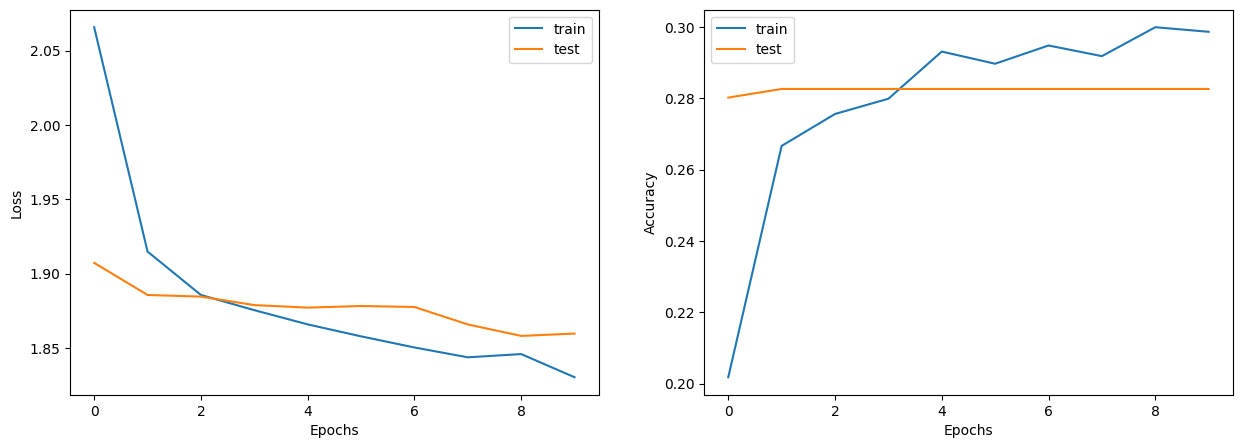

Train accuracy: 29.66%	

In [5]:
gnn_model = GNNNodeClassifier(
    features, 
    np.concatenate((just_edges, np.zeros((2, 100), dtype=np.int64)), axis=1), 
    num_classes=len(np.unique(labels)),
)

history = model_fit(gnn_model, X, y, verbose=0, epoches=10)

plot_learning_curves(history)

_, train_accuracy = gnn_model.evaluate(X, y, verbose=0)
print(f"Train accuracy: {round(train_accuracy * 100, 2)}%", end='\t')

In [11]:
class NodeEnv(py_environment.PyEnvironment):
    def __init__(self, inputs, last_acc, original_path, state_path, classifier):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=len(inputs)-1, name='action'
        )
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(1,), dtype=np.int32, name='observation'
        )

        self.classifier = classifier
        self.classifier.save_weights(original_path)
        self.classifier.save_weights(state_path)
        self.original_path = original_path
        self.state_path = state_path

        self.original_acc = last_acc
        self.original_inputs = inputs

        self._reset()

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = 0
        self._episode_ended = False
        
        self.classifier.load_weights(self.original_path)
        self.last_acc = self.original_acc
        self.attacked_node = set()
        self.state_inputs = deepcopy(self.original_inputs)
        return ts.restart(np.array([self._state], dtype=np.int32))

    def _step(self, target_node):
        if self._episode_ended:
            return self.reset()
        
        if (target_node in self.attacked_node) or (target_node > self.state_inputs.shape[0] - 50):
            return ts.termination(np.array([self._state], dtype=np.int32), -1)

        self.fake_node(target_node)

        if self.calc_perturb() >= 0.05 or len(self.attacked_node) >= 50:
            return ts.termination(np.array([self._state], dtype=np.int32), -1)

        rwd = self._get_reward()
        return ts.transition(np.array([self._state], dtype=np.int32), reward=rwd, discount=1.0)

    def _get_reward(self):
        self.classifier.load_weights(self.state_path)

        history = self.classifier.fit(
            x=np.array([i for i in range(self.state_inputs[0])]),
            y=self.state_inputs[:, 0],
            epochs=20,
            batch_size=256,
            validation_split=0.15,
            verbose=0,
        )
        _, train_accuracy = self.classifier.evaluate(x=np.array([i for i in range(self.state_inputs[0])]), 
                                                     y=self.state_inputs[:, 0], verbose=0)
        res = self.last_acc - train_accuracy

        self.last_acc = train_accuracy
        self.classifier.save_weights(self.state_path)

        return res

    def calc_perturb(self):
        return 0.01

    def fake_node(self, target_node):
        fake_id = self.state_inputs.shape[0] - 50 + self._state + 1
        self._state = self._state + 1
        
        label = np.random.randint(7)
        while label == self.state_inputs[target_node, 0]:
            label = np.random.randint(7)
        self.state_inputs[fake_id, 0] = label

        self.state_inputs[fake_id, 1:1434] = self.state_inputs[target_node, 1:1434]

        # modify edges
        self.state_inputs[fake_id, 1434+target_node] = 1
        self.state_inputs[target_node, 1434+fake_id] = 1

        for i in range(len(self.state_inputs)):
            if self.state_inputs[i, target_node+1434] == 1 and np.random.random() < 0.5:
                self.state_inputs[i, fake_id+1434] = 1
            elif self.state_inputs[target_node, i+1434] == 1 and np.random.random() < 0.5:
                self.state_inputs[fake_id, i+1434] = 1


In [12]:
environment = NodeEnv(inputs.astype(np.int32), 1, './original', './state', gnn_model)
tf_env = tf_py_environment.TFPyEnvironment(environment)

fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(tf_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
    return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal')
    )

dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter
)

agent.initialize()
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [14]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [20]:
from tf_agents.policies import py_tf_eager_policy

In [ ]:
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

table_name = 'uniform_table'

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)


In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Reset the environment.
time_step = tf_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    tf_env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [],
    max_steps=1)

returns = []

for _ in range(20000):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run(time_step)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % 200 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % 1000 == 0:
        avg_return = compute_avg_return(tf_env, agent.policy, 10)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)